# Resistive cube in a deep marine setting

### `emg3d`, `SimPEG`, and `empymod` (background)

Deep marine setting (no airwave); comparison of time-domain computation with `SimPEG` and frequency-domain computation followed by a Fourier transform with `emg3d`; the background response is compared to `empymod`.

In [1]:
import emg3d
import empymod
import discretize
import pymatsolver
import numpy as np
import SimPEG, SimPEG.EM
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

---

# (A) Model

<IPython.core.display.Javascript object>


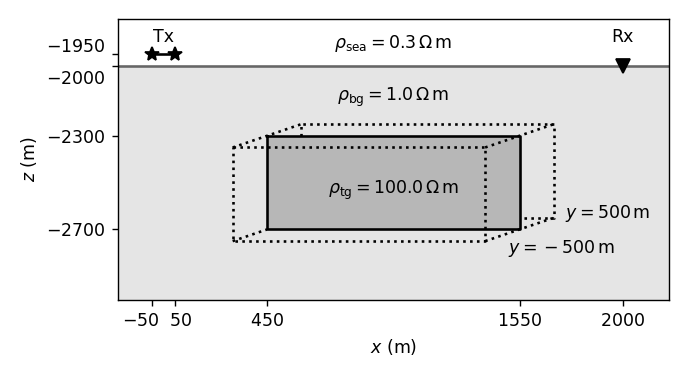

In [3]:
fig = plt.figure(figsize=(5.5, 3))
ax = plt.gca()

# Seafloor and background
plt.plot([-200, 2200], [-2000, -2000], '-', c='.4')
bg = plt.Rectangle((-500, -3000), 3000, 1000, facecolor="black", alpha=0.1)
ax.add_patch(bg)

# Plot survey
plt.plot([-50, 50], [-1950, -1950], '*-', ms=8, c='k')
plt.plot(2000, -2000, 'v', ms=8, c='k')
plt.text(0, -1900, r'Tx', horizontalalignment='center')
plt.text(2000, -1900, r'Rx', horizontalalignment='center')

# Plot cube
plt.plot([450, 1550, 1550, 450, 450], [-2300, -2300, -2700, -2700, -2300], 'k-')
plt.plot([300, 1400, 1400, 300, 300], [-2350, -2350, -2750, -2750, -2350], 'k:')
plt.plot([600, 600, 1700, 1700, 1550], [-2300, -2250, -2250, -2650, -2650], 'k:')
plt.plot([300, 600], [-2350, -2250], 'k:')
plt.plot([1400, 1700], [-2350, -2250], 'k:')
plt.plot([300, 450], [-2750, -2700], 'k:')
plt.plot([1400, 1700], [-2750, -2650], 'k:')
tg = plt.Rectangle((450, -2700), 1100, 400, facecolor="black", alpha=0.2)
ax.add_patch(tg)

# Annotate resistivities
plt.text(1000, -1925, r'$\rho_\mathrm{sea}=0.3\,\Omega\,$m', horizontalalignment='center')
plt.text(1000, -2150, r'$\rho_\mathrm{bg}=1.0\,\Omega\,$m', horizontalalignment='center')
plt.text(1000, -2550, r'$\rho_\mathrm{tg}=100.0\,\Omega\,$m', horizontalalignment='center')
plt.text(1500, -2800, r'$y=-500\,$m', horizontalalignment='left')
plt.text(1750, -2650, r'$y=500\,$m', horizontalalignment='left')

# Ticks and labels
plt.xticks([-50, 50, 450, 1550, 2000], ['$-50~$ $~$  $~$', ' $~50$', '$450$', '$1550$', '$2000$'])
plt.yticks([-1950, -2000, -2300, -2700], ['$-1950$\n', '\n$-2000$', '$-2300$', '$-2700$'])

plt.xlim([-200, 2200])
plt.ylim([-3000, -1800])

plt.xlabel('$x$ (m)')
plt.ylabel('$z$ (m)')
plt.tight_layout()

#plt.savefig('../figures/3d-model.pdf', bbox_inches='tight')
plt.show()

In [4]:
# Resistivities
res_sea = 0.3
res_bg = 1.0
res_tg = 100.0

# Seafloor
seafloor = -2000

# Target dimension
tg_x = [450, 1550]
tg_y = [-500, 500]
tg_z = [-2700, -2300]

---
# (B) Survey

In [5]:
# Source: 100 m x-directed diplole at the origin,
# 50 m above seafloor, src [x1, x2, y1, y2, z1, z2]
src = [-50, 50, 0, 0, -1950, -1950]

# Receiver: x-directed dipole at 2 km on the
# seafloor, rec = [x, y, z, azimuth, dip]
rec = [2000, 0, -2000, 0, 0]

# Times to compute, 0.1 - 10 s, 301 steps
times = np.logspace(-1, 1, 301)

---
# (C) Modelling parameters

### Check diffusion distances

In [6]:
# Get min/max diffusion distances for the two halfspaces.
diff_dist0 = 1261*np.sqrt(np.r_[times*res_sea, times*res_sea])
diff_dist1 = 1261*np.sqrt(np.r_[times*res_bg, times*res_bg])
diff_dist2 = 1261*np.sqrt(np.r_[times*res_tg, times*res_tg])
print("Min/max diffusion distance:")
print(f"- Water      :: {diff_dist0.min():8.0f} / {diff_dist0.max():8.0f} m.")
print(f"- Background :: {diff_dist1.min():8.0f} / {diff_dist1.max():8.0f} m.")
print(f"- Target     :: {diff_dist2.min():8.0f} / {diff_dist2.max():8.0f} m.")

Min/max diffusion distance:
- Water      ::      218 /     2184 m.
- Background ::      399 /     3988 m.
- Target     ::     3988 /    39876 m.


### Time-steps (for TDEM computation with SimPEG)

<IPython.core.display.Javascript object>


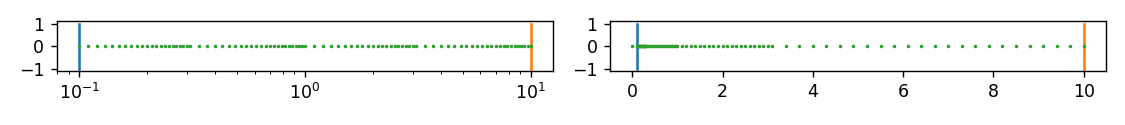

Min/max times    : 1.0e-01 / 1.0e+01
Min/max timeSteps: 1.0e-01 / 1.0e+01


In [7]:
# Time steps
time_steps = [1e-1, (1e-2, 21), (3e-2, 23), (1e-1, 21), (3e-1, 23)]

# Create mesh with time steps
ts = SimPEG.Mesh.TensorMesh([time_steps]).vectorNx

# Plot them
plt.figure(figsize=(9, 1))

# Logarithmic scale
plt.subplot(121)
plt.plot([times.min(), times.min()], [-1, 1])
plt.plot([times.max(), times.max()], [-1, 1])
plt.plot(ts, ts*0, '.', ms=2)
plt.xscale('log')

# Linear scale
plt.subplot(122)
plt.plot([times.min(), times.min()], [-1, 1])
plt.plot([times.max(), times.max()], [-1, 1])
plt.plot(ts, ts*0, '.', ms=2)

plt.tight_layout()
plt.show()

# Check times with time-steps
print(f"Min/max times    : {times.min():.1e} / {times.max():.1e}")
print(f"Min/max timeSteps: {ts[1]:.1e} / {ts[-1]:.1e}")

## Create mesh (`discretize`)

In [8]:
# Cell width, number of cells
width = 100
nx = rec[0]//width+4
ny = 10
nz = 9

# Padding
npadx = 14
npadyz = 12

# Stretching
alpha = 1.3

# Initiate TensorMesh
mesh = discretize.TensorMesh(
    [[(width, npadx, -alpha), (width, nx), (width, npadx, alpha)],
     [(width, npadyz, -alpha), (width, ny), (width, npadyz, alpha)],
     [(width, npadyz, -alpha), (width, nz), (width, npadyz, alpha)]],
    x0='CCC',
)

# Shift mesh so that
# x=0 is at midpoint of source;
# z=-2000 is at receiver level
mesh.x0[0] += rec[0]//2-width/2
mesh.x0[2] -= nz/2*width - seafloor

mesh

TensorMesh: 58,344 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     52    -16,878.63     18,778.63    100.00  3,937.38    1.30
   y     34    -10,162.50     10,162.50    100.00  2,329.81    1.30
   z     33    -12,562.50      7,662.50    100.00  2,329.81    1.30

In [9]:
#mesh.vectorCCx
#mesh.vectorNy
#mesh.vectorNz

### Check if source and receiver are exactly at x-edges.

No requirement; if receiver are exactly on x-edges then no interpolation is required to get the responses
(cell centers in x, cell edges in y, z).

In [10]:
print(f"Rec-{{x;y;z}} :: {rec[0] in np.round(mesh.vectorCCx)!s:>5}; {rec[1] in np.round(mesh.vectorNy)!s:>5}; "
      f"{rec[2] in np.round(mesh.vectorNz)!s:>5}")
print(f"Src-x       :: {src[0] in np.round(mesh.vectorCCx)!s:>5}; {src[1] in np.round(mesh.vectorCCx)!s:>5}")
print(f"Src-y       :: {src[2] in np.round(mesh.vectorNy)!s:>5}; {src[3] in np.round(mesh.vectorNy)!s:>5}")
print(f"Src-z       :: {src[4] in np.round(mesh.vectorNz)!s:>5}; {src[5] in np.round(mesh.vectorNz)!s:>5}")

Rec-{x;y;z} ::  True;  True;  True
Src-x       :: False; False
Src-y       ::  True;  True
Src-z       :: False; False


## Put model on mesh

<IPython.core.display.Javascript object>


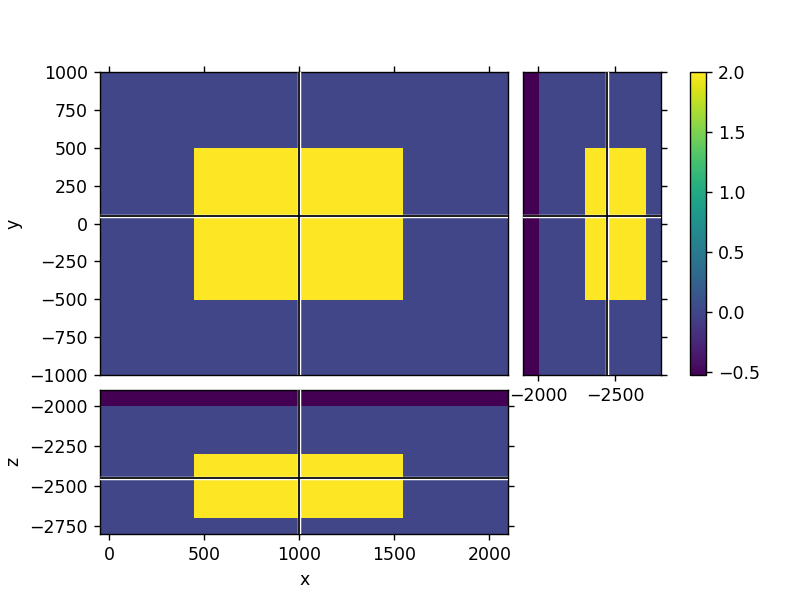

In [11]:
# Background model
mres_bg = np.ones(mesh.nC)*res_sea               # Upper halfspace; sea water
mres_bg[mesh.gridCC[:, 2] < seafloor] = res_bg   # Lower halfspace; background

# Target model
mres_tg = mres_bg.copy()  # Copy background model
target_inds = (  # Find target indices
    (mesh.gridCC[:, 0] >= tg_x[0]) & (mesh.gridCC[:, 0] <= tg_x[1]) &
    (mesh.gridCC[:, 1] >= tg_y[0]) & (mesh.gridCC[:, 1] <= tg_y[1]) &
    (mesh.gridCC[:, 2] >= tg_z[0]) & (mesh.gridCC[:, 2] <= tg_z[1])
)
mres_tg[target_inds] = res_tg  # Target resistivity

# QC
mesh.plot_3d_slicer(
    np.log10(mres_tg), clim=[np.log10(res_sea), np.log10(res_tg)],
    xlim=[-src[0]-100, rec[0]+100], ylim=[-rec[0]/2, rec[0]/2], zlim=[tg_z[0]-100, seafloor+100],
)

---
# (D) `empymod`


Compute the 1D background semi-analytically, using 5 points to approximate the 100-m long dipole.

In [12]:
inp = {
    'src': src.copy(),
    'rec': rec.copy(),
    'depth': seafloor,
    'res': [res_sea, res_bg],
    'freqtime': times,
    'signal': -1,   # Switch-off
    'srcpts': 5,    # 5 points for finite length approx
    'strength': 1,  # Account for source length
    'verb': 1,
}

epm_bg = empymod.bipole(**inp)

---
# (E) `SimPEG`

Set-up SimPEG-specific parameters.

In [13]:
# Define the `Problem`
prob = SimPEG.EM.TDEM.Problem3D_e(
    mesh,
    rhoMap=SimPEG.Maps.IdentityMap(mesh),
    Solver=pymatsolver.Pardiso,
    timeSteps=time_steps,
)


# Set up the receiver list
rec_list = [
    SimPEG.EM.TDEM.Rx.Point_e(
        orientation='x',
        times=times,
        locs=np.array([[*rec[:3]], ]),
    ),
]


# Set up the source list
src_list = [
    SimPEG.EM.TDEM.Src.LineCurrent(
        rxList=rec_list,
        loc=np.array([[*src[::2]], [*src[1::2]]]),
    ),
]


# Create `Survey`
survey = SimPEG.EM.TDEM.Survey(src_list)

# Pair `Problem` to `Survey`
prob.pair(survey)

### Compute

In [14]:
%%time
spg_bg = survey.dpred(mres_bg)
spg_tg = survey.dpred(mres_tg)

CPU times: user 7min 9s, sys: 7.68 s, total: 7min 16s
Wall time: 3min 42s


---
# (F) `emg3d`

### Fourier-transform and Model instances

In [15]:
# We use the frequency range as given by the FFTLog
F = emg3d.utils.Fourier(
    time=times,
    fmin=0.001,
    fmax=10,
    signal=-1,
    ft='fftlog',
    ftarg={'pts_per_dec': 5},
)

print("\n---\n")

# But for the actual transform, we use DLF
Fourier = emg3d.utils.Fourier(
    time=F.time,
    fmin=F.fmin,
    fmax=F.fmax,
    signal=F.signal,
    ft='cos',
    freq_inp=F.freq_calc
)

   time        [s] :  0.1 - 10 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  0.000200364 - 12.6421 : 25  [min-max; #]
   Calc. freq [Hz] :  0.00126421 - 7.97664 : 20  [min-max; #]

---

   time        [s] :  0.1 - 10 : 301  [min-max; #]
   Fourier         :  DLF (Cosine-Filter)
     > Filter      :  Key 201 CosSin (2012)
     > DLF type    :  Lagged Convolution
   Req. freq  [Hz] :  1.4626E-08 - 1.95429E+06 : 235  [min-max; #]
   Calc. freq [Hz] :  0.00126421 - 7.97664 : 20  [min-max; #]


In [16]:
# General input for the emg3d-solver
sinp = {'verb': -1, 'sslsolver': True, 'semicoarsening': True, 'linerelaxation': True}

# General input for gridding
gridinput = {
    'min_width': 100,     # Fix the cell width within the survey domain to 100 m.
    'max_domain': 30000,  # Maximum computation domain
    'verb': 0,
    'alpha': [1, 1.5, 0.01],
}

# Define Model instances for the two models
model_bg_orig = emg3d.utils.Model(mesh, mres_bg)
model_tg_orig = emg3d.utils.Model(mesh, mres_tg)

# Pre-allocate data
data_bg = np.zeros(Fourier.freq_calc.size, dtype=complex)
data_tg = np.zeros(Fourier.freq_calc.size, dtype=complex)

### Compute

In [17]:
%%time

# Loop over frequencies, going from high to low.
for fi, frq in enumerate(Fourier.freq_calc[::-1]):
    print(f"=> {fi+1:2}/{Fourier.freq_calc.size} :: {frq:10.6f} Hz; #cells: ", end='')

    # Get cell widths and origin in each direction
    xx, x0 = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1], fixed=src[0], domain=[-100, 2100], **gridinput)
    yy, y0 = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1], fixed=0, domain=[-500, 500], **gridinput)
    zz, z0 = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1.], domain=[-2800, -1900], **gridinput, fixed=[-2300, -2000, -2700])

    # Initiate mesh.
    grid = discretize.TensorMesh([xx, yy, zz], x0=np.array([x0, y0, z0]))
    print(grid.nC)

    # Interpolate the starting electric field from the last one
    # (can speed-up the computation).
    if fi == 0:
        efield = emg3d.utils.Field(grid, freq=frq)
    else:
        efield = emg3d.utils.grid2grid(
            old_grid, efield, grid, method='cubic', extrapolate=False)
        efield = emg3d.utils.Field(grid, efield, freq=frq)
    
    # Put model on mesh
    res_x_bg = emg3d.utils.grid2grid(mesh, model_bg_orig.res_x, grid, 'volume', log=True)
    res_x_tg = emg3d.utils.grid2grid(mesh, model_tg_orig.res_x, grid, 'volume', log=True)
    model_bg = emg3d.utils.Model(grid, res_x_bg)
    model_tg = emg3d.utils.Model(grid, res_x_tg)

    # Define source.
    sfield = emg3d.utils.get_source_field(grid, [*src], frq, strength=1)

    # Solve the system.
    efield_bg = emg3d.solve(grid, model_bg, sfield, **sinp)
    efield_tg = emg3d.solve(grid, model_tg, sfield, **sinp)

    # Get response at receiver
    data_bg[fi] = emg3d.utils.get_receiver(grid, efield_bg.fx, (rec[0], rec[1], rec[2]))
    data_tg[fi] = emg3d.utils.get_receiver(grid, efield_tg.fx, (rec[0], rec[1], rec[2]))

    # Store the grid for the interpolation.
    old_grid = grid

=>  1/20 ::   7.976643 Hz; #cells: 18432
:: emg3d :: 2.8e-08; 1(3); 0:00:01; CONVERGED
:: emg3d :: 8.0e-08; 1(3); 0:00:01; CONVERGED
=>  2/20 ::   5.032921 Hz; #cells: 18432
:: emg3d :: 6.3e-07; 1(3); 0:00:01; CONVERGED
:: emg3d :: 7.0e-07; 1(3); 0:00:01; CONVERGED
=>  3/20 ::   3.175559 Hz; #cells: 18432
:: emg3d :: 6.4e-08; 1(4); 0:00:01; CONVERGED
:: emg3d :: 8.4e-08; 1(4); 0:00:01; CONVERGED
=>  4/20 ::   2.003642 Hz; #cells: 23040
:: emg3d :: 4.8e-08; 1(4); 0:00:01; CONVERGED
:: emg3d :: 1.3e-07; 1(4); 0:00:01; CONVERGED
=>  5/20 ::   1.264213 Hz; #cells: 23040
:: emg3d :: 2.9e-07; 1(4); 0:00:01; CONVERGED
:: emg3d :: 4.2e-07; 1(4); 0:00:01; CONVERGED
=>  6/20 ::   0.797664 Hz; #cells: 23040
:: emg3d :: 3.6e-07; 1(5); 0:00:02; CONVERGED
:: emg3d :: 3.4e-07; 1(5); 0:00:02; CONVERGED
=>  7/20 ::   0.503292 Hz; #cells: 23040
:: emg3d :: 9.1e-08; 1(6); 0:00:02; CONVERGED
:: emg3d :: 8.4e-08; 1(6); 0:00:02; CONVERGED
=>  8/20 ::   0.317556 Hz; #cells: 40960
:: emg3d :: 9.2e-07; 1(5); 0

### Fourier transform

In [18]:
egd_bg = Fourier.freq2time(data_bg[::-1], rec[0])
egd_tg = Fourier.freq2time(data_tg[::-1], rec[0])

---
# (G) Plots

<IPython.core.display.Javascript object>


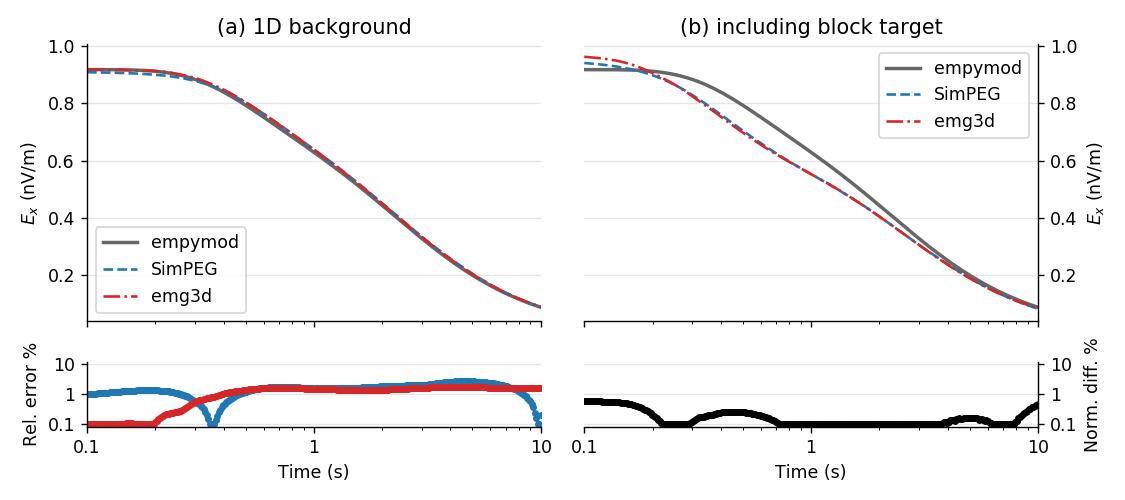

In [19]:
plt.figure(figsize=(9, 4))

# # # Plot Responses  # # #
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=3)
plt.title('(a) 1D background')

plt.plot(times, epm_bg*1e9, '.4', lw=2, label='empymod')

plt.plot(times, spg_bg*1e9, 'C0--', label='SimPEG')
plt.plot(times, egd_bg*1e9, 'C3-.', label='emg3d')

plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')
plt.xlim([0.1, 10])
ax1.set_xticklabels([])
plt.legend(loc=3)
plt.grid(axis='y', c='0.9')


# # # Plot Relative Error (%) # # #
ax2 = plt.subplot2grid((4, 2), (3, 0))

err_spg = np.clip(100*abs((epm_bg-spg_bg)/epm_bg), 0.1, 10)
err_egd = np.clip(100*abs((epm_bg-egd_bg)/epm_bg), 0.1, 10)

plt.plot(times, err_spg, 'C0.')
plt.plot(times, err_egd, 'C3.')

plt.xscale('log')
plt.yscale('log')
plt.xlim(ax1.get_xlim())
plt.ylabel('Rel. error %')
plt.ylim([8e-2, 12])
plt.yticks([0.1, 1, 10], ('0.1', '1', '10'))
plt.xticks([0.1, 1, 10], ('0.1', '1', '10'))
plt.grid(axis='y', c='0.9')
plt.xlabel('Time (s)')


# # # Plot target model # # #
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=3, sharey=ax1)
plt.title('(b) including block target')

plt.plot(times, epm_bg*1e9, '.4', lw=2, label='empymod')

plt.plot(times, spg_tg*1e9, 'C0--', label='SimPEG')
plt.plot(times, egd_tg*1e9, 'C3-.', label='emg3d')

plt.xlim([0.1, 10])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('$E_x$ (nV/m)')
ax3.set_xticklabels([])
plt.legend()
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')


# # # Normalized Difference # # #
ax4 = plt.subplot2grid((4, 2), (3, 1))

norm_diff = np.clip(50*abs((egd_tg-spg_tg)/(egd_tg+spg_tg)), 0.1, 10)
plt.plot(times, norm_diff, 'k.')

plt.xscale('log')
plt.yscale('log')
plt.xlim(ax1.get_xlim())
plt.xlabel('Time (s)')
plt.ylabel('Norm. diff. %')
plt.ylim([8e-2, 12])
plt.yticks([0.1, 1, 10], ('0.1', '1', '10'))
plt.xticks([0.1, 1, 10], ('0.1', '1', '10'))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Switch off spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)

plt.tight_layout()
#plt.savefig('../figures/3d-result.pdf', bbox_inches='tight')
plt.show()

## Write and load the data

In [24]:
#emg3d.utils.data_write(
#    '3D-Block',
#    ['spg_bg', 'spg_tg', 'egd_bg', 'egd_tg', 'epm_bg', 'times'],
#    [spg_bg, spg_tg, egd_bg, egd_tg, epm_bg, times],
#    path='../data/',
#)

In [21]:
# spg_bg, spg_tg, egd_bg, egd_tg, epm_bg, times = emg3d.utils.data_read(
#         '3D-Block', ['spg_bg', 'spg_tg', 'egd_bg', 'egd_tg', 'epm_bg', 'times'],
#         path='../data/')

In [22]:
empymod.Report([emg3d, SimPEG, discretize])

--------------------------------------------------------------------------------
  Date: Thu Mar 05 19:39:24 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

             emg3d : 0.9.3
            SimPEG : 0.13.1
        discretize : 0.4.10
             numpy : 1.17.2
             scipy : 1.3.1
           empymod : 1.10.6
           numexpr : 2.7.0
           IPython : 7.8.0
        matplotlib : 3.1.1

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------